# CAPSTONE
## Battle of the Neighborhoods
### __Indian Restaurants__

#### __Introduction__
This final project explores the best locations for Indian restaurants throughout the city of New York. Food Business News stated that worldwide pasta sales were up for the second year in a row with the United Sates holding the largest market.  New York is a major metropolitan area with more than 8.4 million (Quick Facts, 2018) people living within city limits. This report explores which neighborhoods and boroughs of New York City have the most as well as the best Indian restaurants. Additionally, I will attempt to answer the questions “Where should I open an Indian Restaurant?” and “Where should I stay If I want great Indian food?”

### __Data__
In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of Indian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.



### __Methodology__
•	Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

•	FourSquare be used to locate all venues and then filtered by Indian restaurants.  Ratings, tips, and likes by users will be counted and added to the dataframe.

•	Data will be sorted based on rankings

•	Finally, the data be will be visually assessed using graphing from various Python libraries.

### __Problem Statement__
1.	What is / are the best location(s) for Indian cuisine in New York City?
2.	In what Neighborhood and/or borough should I open an Indian restaurant to have the best chance of being successful?
3.	Where would I go in New York City to have the best Indian food?

Load Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Done!


Functions that will be used later

In [0]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng,radius,LIMIT):
    #set variables
    #radius=400
    #LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

Now lets use the above codes to get our initial NYC data

In [0]:
#Foursquare_api
CLIENT_ID = "FG03S1PEXXF32IF3PFDDIOT2SK4MIT2ETW3RSYOBUUSVPO4M" 
CLIENT_SECRET = "JHYQYGCY2XH1QWDXB4VO1SNJT1GO0CCDILIQK24SHWP222ET" 
VERSION = '20191223'

In [4]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [0]:
ny_data.shape

(306, 4)

Now that we have our initial data, lets start analyzing it. We can see below that Manhattan has the least number of neighborhoods in all five buroughs. 

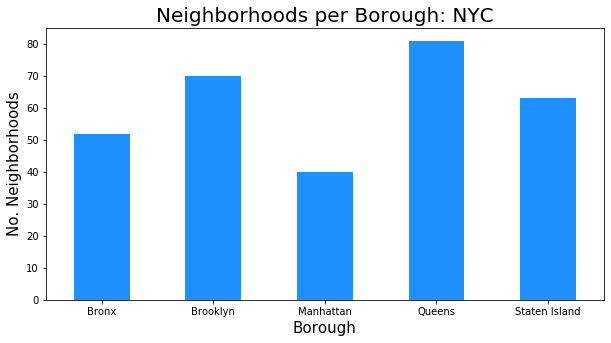

In [0]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Lets analyze further and see how many Indian restaurants there are in each neighborhood and burough and graph the results.

In [0]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude,1000,100)
    Indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(ny_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(Indian_resturants)))
    print(row,"\n")
    for resturant_detail in Indian_resturants.values.tolist():
        id, name , category=resturant_detail
        Indian_rest_ny = Indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [0]:
Indian_rest_ny.to_csv('Indian_rest_ny.csv',index=False) 
# Save the information so far to a .csv file due to limited calls on FourSquare

In [0]:
Indian_rest_ny = Indian_rest_ny.drop(["Unnamed: 0"],axis=1)

In [5]:
Indian_rest_ny = pd.read_csv('Indian_rest_ny.csv')
Indian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
150,Brooklyn,Erasmus,564d283d498e6e851df79d87,Great Indian Curry
151,Brooklyn,Erasmus,4e8b96bed3e303e9db3555fd,Bombay Masala
152,Queens,Queensbridge,50a287a7e4b0033f830f06db,Raj's Indian Kitchen
153,Queens,Queensbridge,4b1b341bf964a5208af923e3,Five Star Banquet
154,Staten Island,Fox Hills,4b65f2e3f964a5206e0a2be3,Al-Humza


In [6]:
Indian_rest_ny.shape

(155, 4)

As we continue our analysis, we see below that although Manhattan had the least number of nieghborhoods, it does have the highest number if Indian restaurants.  Additionally, we see how many restaurants the top 6 neighborhoods have.  The neighborhood of Belmont has the highest number of Indian restaurants in all of NYC and is actually located in the burough of Bronx vice Manhattan.

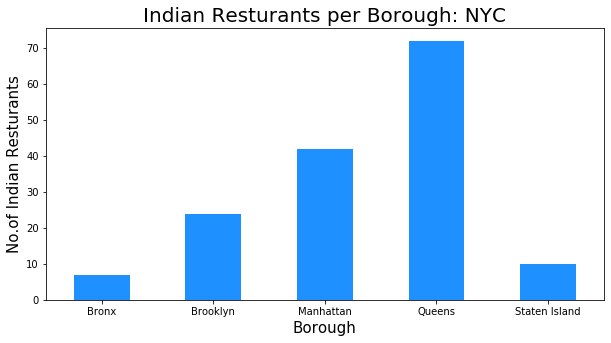

In [0]:
Indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Indian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Indian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

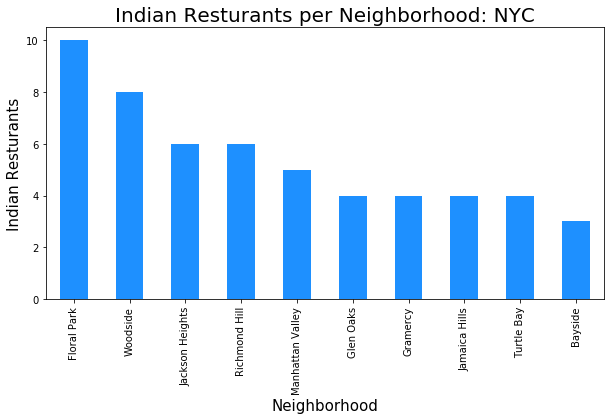

In [0]:
NOofNeigh = 10 # top number for graphing all the same past 6
Indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Indian Resturants', fontsize=15)
plt.xticks(rotation = 90)
plt.show()

In [0]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
#Borough, Neighborhood, Latitude, Longitude=row
for row in Indian_rest_ny.values.tolist():
  Borough, Neighborhood, ID, Name=row
  try:
      venue_details=get_venue_details(ID)
      print(venue_details)
      id,name,likes,rating,tips=venue_details.values.tolist()[0]
  except IndexError:
      print('No data available for id=',ID)
      # we will assign 0 value for these resturants as they may have been 
      #recently opened or details does not exist in FourSquare Database
      id,name,likes,rating,tips=[0]*5
  print('(',count,'/',len(Indian_rest_ny),')','processed')
  Indian_rest_stats_ny = Indian_rest_stats_ny.append({'Borough': Borough,
                                              'Neighborhood': Neighborhood, 
                                              'ID': id,
                                              'Name' : name,
                                              'Likes' : likes,
                                              'Rating' : rating,
                                              'Tips' : tips
                                              }, ignore_index=True)
  count+=1

In [9]:
Indian_rest_ny.values.tolist()

[['Bronx', 'Woodlawn', '4c0448d9310fc9b6bf1dc761', 'Curry Spot'],
 ['Bronx',
  'Parkchester',
  '4c194631838020a13e78e561',
  'Melanies Roti Bar And Grill'],
 ['Bronx',
  'Spuyten Duyvil',
  '4c04544df423a593ac83d116',
  'Cumin Indian Cuisine'],
 ['Bronx', 'Concourse', '551b7f75498e86c00a0ed2e1', 'Hungry Bird'],
 ['Bronx',
  'Unionport',
  '4c194631838020a13e78e561',
  'Melanies Roti Bar And Grill'],
 ['Bronx',
  'Unionport',
  '55dfa36a498e164ef19bef7b',
  'Premium Sweets & Restaurant'],
 ['Brooklyn', 'Bay Ridge', '4b5a4dc8f964a520a2bb28e3', 'Taj Mahal'],
 ['Brooklyn', 'Brighton Beach', '4af0d31bf964a5207ddf21e3', 'Pak Nasheman'],
 ['Brooklyn', 'Flatbush', '52213c4211d295d4c57a607c', 'Ashoka Grill'],
 ['Brooklyn', 'Flatbush', '564d283d498e6e851df79d87', 'Great Indian Curry'],
 ['Brooklyn', 'East Flatbush', '512a9ea9e4b004fb8eeb84e5', 'Silver Krust'],
 ['Brooklyn', 'Kensington', '4db0f4371e729fcc56497f20', 'Mashallah'],
 ['Brooklyn',
  'Kensington',
  '4b718914f964a520c04b2de3',
  'Mad

In [0]:
Indian_rest_stats_ny.to_csv('Indian_rest_stats_ny_csv1.csv') # I continue to save data to a .csv as I move through this project

In [11]:
Indian_rest_stats_ny.shape

(50, 7)

In [12]:
Indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [13]:
Indian_rest_stats_ny['Likes']=Indian_rest_stats_ny['Likes'].astype('float64')
Indian_rest_stats_ny['Tips']=Indian_rest_stats_ny['Tips'].astype('float64')
Indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [14]:
Indian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.000000,50.000000,50.000000
mean,62.480000,7.548000,23.520000
std,103.282304,1.720612,32.457344
min,0.000000,0.000000,0.000000
25%,13.000000,7.425000,4.000000
50%,26.000000,7.900000,13.500000
75%,75.000000,8.500000,25.750000
max,589.000000,9.000000,160.000000


In [15]:
# Resturant with maximum Likes
Indian_rest_stats_ny.iloc[Indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                589
Rating                                 9
Tips                                 148
Name: 40, dtype: object

In [16]:
# Resturant with maximum Ratings
Indian_rest_stats_ny.iloc[Indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                589
Rating                                 9
Tips                                 148
Name: 40, dtype: object

In [17]:
# Resturant with maximum Tips
Indian_rest_stats_ny.iloc[Indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a70a75bf964a52016d81fe3
Name                 Bhatti Indian Grill
Likes                                415
Rating                               8.7
Tips                                 160
Name: 49, dtype: object

In [18]:
ny_neighborhood_stats=Indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
27,Tribeca,9.0
12,Greenwich Village,8.9
31,West Village,8.8
18,Murray Hill,8.8
3,Chelsea,8.7
5,Clinton Hill,8.7
10,Fort Greene,8.7
11,Gramercy,8.7
33,Yorkville,8.5
25,South Side,8.5


In [19]:
ny_borough_stats=Indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.146154
1,Brooklyn,7.361111
0,Bronx,5.516667


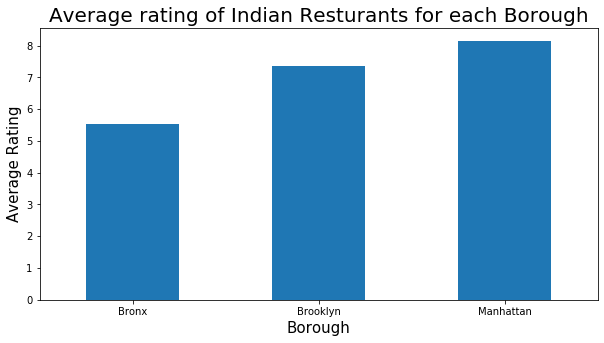

In [22]:
Indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5))
plt.title('Average rating of Indian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

We will visually map the neighborhoods with an average rating greater than or equal to 8 after joining the approprite dfs to include latitudes and longitudes.

In [23]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats[:5]

,Neighborhood,Average Rating
0,Bay Ridge,8.30
2,Central Harlem,8.05
3,Chelsea,8.70
5,Clinton Hill,8.70
7,East Flatbush,8.00


In [24]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats[:5]

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bay Ridge,40.625801,-74.030621,8.30
1,Manhattan,Central Harlem,40.815976,-73.943211,8.05
2,Manhattan,Chelsea,40.744035,-74.003116,8.70
3,Staten Island,Chelsea,40.594726,-74.189560,8.70
4,Brooklyn,Clinton Hill,40.693229,-73.967843,8.70


In [0]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [26]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [0]:
ny_neighborhood_stats.to_json("abc.json")

In [32]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'https://raw.githubusercontent.com/WiMLDS/smart_cities/master/NYC_shapefiles/Borough%20Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_neighborhood_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating1.html')

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Finally, we will visualize all NYC buroughs based on average Rating.

In [31]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'https://raw.githubusercontent.com/WiMLDS/smart_cities/master/NYC_shapefiles/Borough%20Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating')
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


click [here](https://github.com/anandsubbu007/Coursera_Capstone/blob/master/Capture.JPG) to see the chorpleth map of average ratings

### __Results / Conclusion__
Manhattan and Brooklyn have the best rated Indian restaurants on average. Queens and The Bronx have the least amount of Indian restaurants per borough. However, of note, Belmont of The Bronx is the neighborhood in all of NYC with the most Indian Restaurants. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most Indian restaurants.  Based on this information, I would state that Manhattan and Brooklyn are the best locations for Indian cuisine in NYC. To have the best shot of success, I would open an Indian restaurants in Brooklyn. Brooklyn	 has multiple neighborhoods with average ratings exceeding 8 of a scale of 1.0 to 10.0 and has the least number of Indian restaurants making competition easier than in other boroughs. As a final note, all of the above analysis is depended  on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.

In [33]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
0,Brooklyn,Bay Ridge,40.625801,-74.030621,8.30,"Bay Ridge, Brooklyn(8.3)"
1,Manhattan,Central Harlem,40.815976,-73.943211,8.05,"Central Harlem, Manhattan(8.05)"
2,Manhattan,Chelsea,40.744035,-74.003116,8.70,"Chelsea, Manhattan(8.7)"
3,Staten Island,Chelsea,40.594726,-74.189560,8.70,"Chelsea, Staten Island(8.7)"
4,Brooklyn,Clinton Hill,40.693229,-73.967843,8.70,"Clinton Hill, Brooklyn(8.7)"
5,Brooklyn,East Flatbush,40.641718,-73.936103,8.00,"East Flatbush, Brooklyn(8.0)"
6,Brooklyn,Fort Greene,40.688527,-73.972906,8.70,"Fort Greene, Brooklyn(8.7)"
7,Manhattan,Gramercy,40.737210,-73.981376,8.70,"Gramercy, Manhattan(8.7)"
8,Manhattan,Greenwich Village,40.726933,-73.999914,8.90,"Greenwich Village, Manhattan(8.9)"
9,Manhattan,Morningside Heights,40.808000,-73.963896,8.00,"Morningside Heights, Manhattan(8.0)"
